# KNN Binary Citrus
- 오렌지인지 자몽인지 분류

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 알고리즘, 함수 내 랜덤으로 진행해야하는 값들이 있음
# 원하는대로 주면 됨(42를 많이 사용함)
SEED = 42

In [ ]:
np.random.seed(SEED)
np.random.random(), np.random.random()

(0.3745401188473625, 0.9507143064099162)

## 1. 데이터 준비

In [ ]:
#!wget https://raw.githubusercontent.com/devdio/flyai_datasets/main/citrus.csv

In [ ]:
citrus = pd.read_csv('citrus.csv')
citrus.shape

(10000, 6)

In [ ]:
citrus.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [ ]:
# 데이터를 copy해둠, 여러 방식으로 처리가 가능하도록
df = citrus.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
diameter,10000.0,9.975685,1.947844,2.96,8.46,9.980,11.4800,16.45
weight,10000.0,175.050792,29.212119,86.76,152.22,174.985,197.7225,261.51
red,10000.0,153.847800,10.432954,115.00,147.00,154.000,161.0000,192.00
green,10000.0,76.010600,11.708433,31.00,68.00,76.000,84.0000,116.00
blue,10000.0,11.363200,9.061275,2.00,2.00,10.000,17.0000,56.00


### 범주형 변수

In [ ]:
# name만 범주형 데이터
df['name'].nunique()

2

In [ ]:
df['name'].value_counts()

name
orange        5000
grapefruit    5000
Name: count, dtype: int64

<Axes: xlabel='name'>

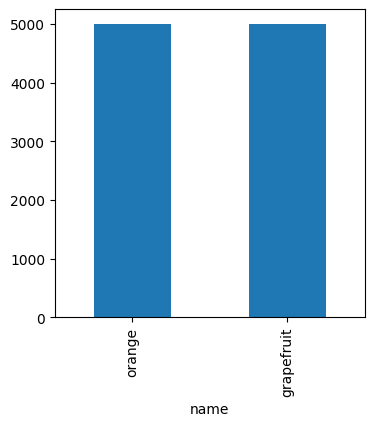

In [ ]:
# 막대그래프 그리기
df['name'].value_counts().plot(kind='bar', figsize=(4, 4))

### 연속형 변수

In [ ]:
# name이 orange인 데이터만 뽑아서 히스토그램 그리기
df_orange = df[df['name'] == 'orange']
df_grape = df[df['name'] == 'grapefruit']

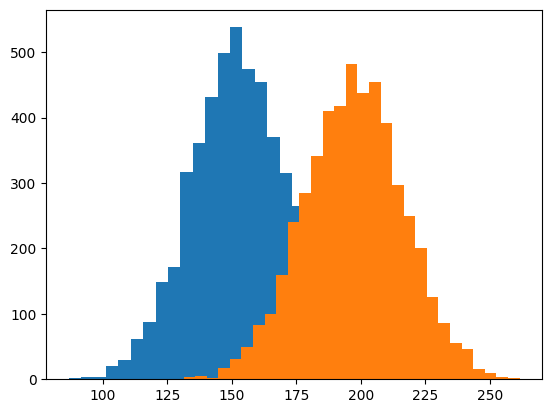

In [ ]:
plt.hist(df_orange['weight'], bins=30)
plt.hist(df_grape['weight'], bins=30)
plt.show()

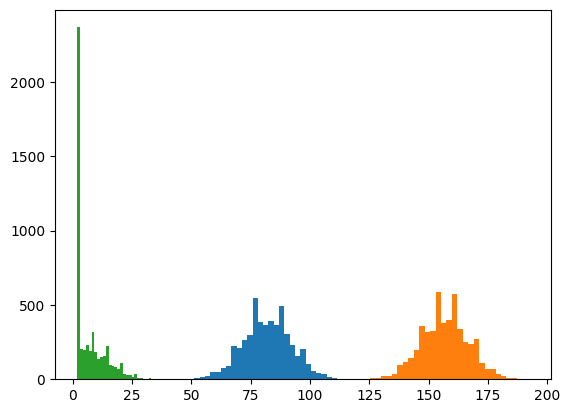

In [ ]:
# 여러 개를 한 그래프 안에 그리기
plt.hist(df_orange['green'], bins=30)
plt.hist(df_orange['red'], bins=30)
plt.hist(df_orange['blue'], bins=30)
plt.show()

In [ ]:
df.columns

Index(['name', 'diameter', 'weight', 'red', 'green', 'blue'], dtype='object')

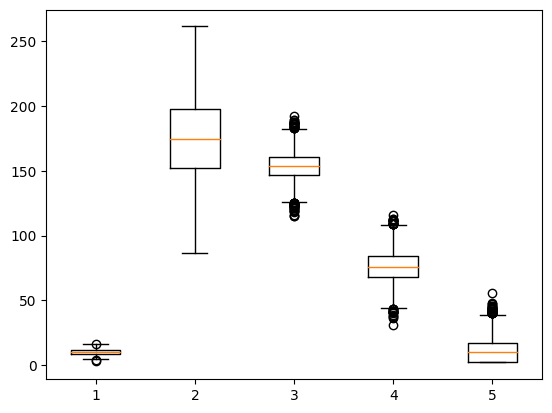

In [ ]:
plt.boxplot(df[['diameter', 'weight', 'red', 'green', 'blue']])
plt.show()

### 결측치(Missing Values)

In [ ]:
# 결측치 확인 - sum을 통해 없는 것을 확인할 수 있음
df.isna().sum(axis=0)

name        0
diameter    0
weight      0
red         0
green       0
blue        0
dtype: int64

### 중복치

In [ ]:
# 중복치 확인
df.duplicated().sum()

0

## 2. 학습용, 테스트 분리

In [ ]:
# 데이터 섞기
df = df.sample(frac = 1) # 1을 주면 전체를 갈아엎어 버림
df.head()

,name,diameter,weight,red,green,blue
6883,grapefruit,11.07,191.32,168,60,33
5836,grapefruit,10.29,178.69,139,84,5
8601,grapefruit,12.20,208.40,161,59,11
2545,orange,8.51,153.06,147,70,5
8697,grapefruit,12.27,209.52,151,79,2


In [ ]:
# 섞고 나서 test, train, val을 뽑기
# sklearn split을 이용해서 내부적으로 나눠줌
# pandas slice 기능을 사용해서 나누기
idx_train = int(len(df) * 0.6)
idx_val = int(len(df) * 0.8)

In [ ]:
train = df.iloc[:idx_train, :]
val = df.iloc[idx_train:idx_val, :]
test = df.iloc[idx_val:, :]

train.shape, val.shape, test.shape

((6000, 6), (2000, 6), (2000, 6))

### X, y 변수 분리

In [ ]:
# name이 y값(종속 변수), 나머지 값이 독립변수 X
X_train = train.drop('name', axis = 1)
y_train = train['name']

In [ ]:
X_val = val.drop('name', axis = 1)
y_val = val['name']

In [ ]:
# 잘 나눠졌는지 확인
y_train.value_counts(), y_val.value_counts()

(name
 orange        3063
 grapefruit    2937
 Name: count, dtype: int64,
 name
 grapefruit    1041
 orange         959
 Name: count, dtype: int64)

## 스케일링

In [ ]:
# 이상치, 중복치, 결측치도 없으므로 전처리할 내용이 없음
# 스케일링을 해서 바로 집어넣도록 함
# 표준화 진행 - column 단위로 진행해야 함(각각의 평균, 표준편차 구함)
# 표준화 - test는 그대로 들어와서 모델에 적용
# test 데이터는 전처리를 진행하면 무조건 결과가 좋게나올 수밖에 없음
u = X_train.mean()
std = X_train.std() # 표준편차
u, std

(diameter      9.931100
 weight      174.386193
 red         154.101500
 green        76.165833
 blue         11.136500
 dtype: float64,
 diameter     1.946994
 weight      29.174072
 red         10.438168
 green       11.717873
 blue         8.931900
 dtype: float64)

In [ ]:
# 표준화
X_train_s = (X_train - u) / std
X_train_s.head()

,diameter,weight,red,green,blue
6883,0.584953,0.580440,1.331508,-1.379588,2.447800
5836,0.184335,0.147522,-1.446758,0.668566,-0.687032
8601,1.165335,1.165892,0.660892,-1.464927,-0.015282
2545,-0.729895,-0.730998,-0.680340,-0.526190,-0.687032
8697,1.201288,1.204282,-0.297131,0.241867,-1.022907


In [ ]:
X_val_s = (X_val - u) / std
X_val_s.head()

,diameter,weight,red,green,blue
7292,0.708220,0.720976,-0.297131,-0.270171,1.440175
278,-1.772528,-1.763422,2.193728,0.583226,-0.910948
3252,-0.509041,-0.492087,-0.776142,1.180604,1.216259
2480,-0.755575,-0.751222,-0.392933,-0.014152,-0.798990
289,-1.757119,-1.754167,-0.105526,0.156527,-0.127241


In [ ]:
# 평균, 표준편차 저장(u, std) -> test 데이터 전처리도 이를 이용해서 진행
ss_dic = {'mean':u, 'std':std}
ss_dic

{'mean': diameter      9.931100
 weight      174.386193
 red         154.101500
 green        76.165833
 blue         11.136500
 dtype: float64,
 'std': diameter     1.946994
 weight      29.174072
 red         10.438168
 green       11.717873
 blue         8.931900
 dtype: float64}

## 인코딩

In [ ]:
label_dict = {'grapefruit':0, 'orange':1}

In [ ]:
y_train # 문자열을 숫자로 바꿀 것

6883    grapefruit
5836    grapefruit
8601    grapefruit
2545        orange
8697    grapefruit
           ...    
4776        orange
4276        orange
253         orange
6175    grapefruit
9593    grapefruit
Name: name, Length: 6000, dtype: object

In [ ]:
y_train_e = y_train.map(label_dict)
y_val_e = y_val.map(label_dict)
y_train_e, y_val_e # 1, 0이 뭔지 알려면 dict가 있어야 함

(6883    0
 5836    0
 8601    0
 2545    1
 8697    0
        ..
 4776    1
 4276    1
 253     1
 6175    0
 9593    0
 Name: name, Length: 6000, dtype: int64,
 7292    0
 278     1
 3252    1
 2480    1
 289     1
        ..
 1382    1
 2148    1
 6928    0
 5671    0
 1638    1
 Name: name, Length: 2000, dtype: int64)

In [ ]:
# 전처리 종료
X_train_s
#y_train_e # series 타입

,diameter,weight,red,green,blue
6883,0.584953,0.580440,1.331508,-1.379588,2.447800
5836,0.184335,0.147522,-1.446758,0.668566,-0.687032
8601,1.165335,1.165892,0.660892,-1.464927,-0.015282
2545,-0.729895,-0.730998,-0.680340,-0.526190,-0.687032
8697,1.201288,1.204282,-0.297131,0.241867,-1.022907
...,...,...,...,...,...
4776,0.364100,0.339816,-0.584537,-0.611530,0.208634
4276,-0.077607,-0.040659,-0.009724,0.412546,-1.022907
253,-1.808480,-1.797356,1.331508,0.839245,-1.022907
6175,0.348691,0.307595,0.277683,0.241867,0.880384


In [ ]:
X_train_s = X_train_s.to_numpy()
y_train_e = y_train_e.to_numpy()

X_val_s = X_val_s.to_numpy()
y_val_e = y_val_e.to_numpy()

In [ ]:
print(X_train_s.shape, y_train_e.shape) # 개수가 같아야 함(다르면 error 남)
print(X_val_s.shape, y_val_e.shape)
print(type(X_train_s), type(y_train_e))
print(type(X_val_s), type(y_val_e))

(6000, 5) (6000,)
(2000, 5) (2000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 모델 학습

In [ ]:
# scikit-learn 라이브러리 사용
from sklearn.neighbors import KNeighborsClassifier # 회귀는 import KNeighborsRegressor

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train_s, y_train_e) # 지도학습이 실행됨, 모델이 만들어짐, 학습 완료

KNeighborsClassifier()

## 검증

In [ ]:
# 검증 데이터 이용
y_pred = clf.predict(X_val_s)

In [ ]:
y_val_e

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
(y_pred == y_val_e).sum()/len(y_val_e) # 정확도가 나옴

0.9255

## 테스트

In [206]:
# test 데이터 사용
test.shape

(2000, 6)

In [207]:
test.head()

,name,diameter,weight,red,green,blue
5891,grapefruit,10.35,179.58,166,94,18
7427,grapefruit,11.40,196.71,137,49,18
608,orange,7.00,131.46,157,89,2
6907,grapefruit,11.09,191.62,151,88,2
399,orange,6.70,126.50,168,80,3


In [221]:
X_test = test.drop('name', axis = 1)
y_test = test['name']

In [229]:
#X_test_s = (X_test - ss_dic['mean']) / ss_dic['std']
X_test_s = (X_test - u) / std
y_test_e = y_test.map(label_dict)

In [230]:
X_test_s = X_test_s.to_numpy()
y_test_e = y_test_e.to_numpy()

In [231]:
X_test_s.shape, y_test_e.shape

((2000, 5), (2000,))

In [232]:
y_pred = clf.predict(X_test_s)

In [233]:
(y_pred == y_test_e).sum()/len(y_test_e)

0.9165

In [234]:
# 교차 행렬
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(y_test_e, y_pred)
cfm

array([[939,  83],
       [ 84, 894]])

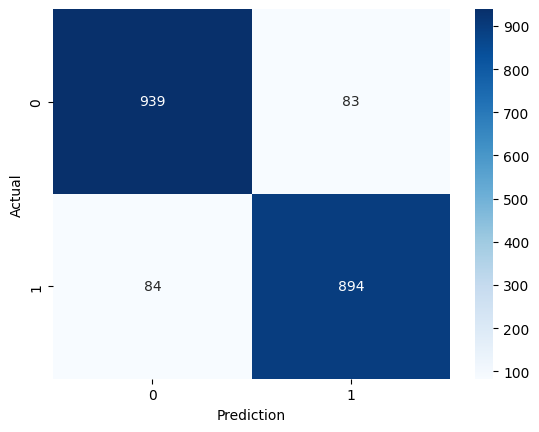

In [239]:
# 보기 쉽게 그래프로 그리기
s = sns.heatmap(cfm, annot=True, cmap='Blues', fmt = 'd')
s.set(xlabel='Prediction', ylabel='Actual')
plt.show()

In [243]:
# 정확도 계산, 재현율, 민감도, f1_score(항상 정답 먼저 적음)
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print("accuracy:",accuracy_score(y_test_e, y_pred))
print("recall_score:",recall_score(y_test_e, y_pred))
print("precision_score:",precision_score(y_test_e, y_pred))
print("f1_score:",f1_score(y_test_e, y_pred))

accuracy: 0.9165
recall_score: 0.9141104294478528
precision_score: 0.9150460593654043
f1_score: 0.9145780051150895


In [248]:
scores = []
for k in range(3, 30):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_s, y_train_e)
    y_pred = clf.predict(X_val_s)
    acc = accuracy_score(y_val_e, y_pred)
    scores.append(acc)
print(scores)

[0.9185, 0.9155, 0.9255, 0.921, 0.924, 0.9255, 0.9265, 0.9265, 0.9275, 0.928, 0.926, 0.93, 0.928, 0.9275, 0.927, 0.9255, 0.9275, 0.927, 0.9275, 0.925, 0.927, 0.927, 0.9265, 0.928, 0.928, 0.9275, 0.9285]


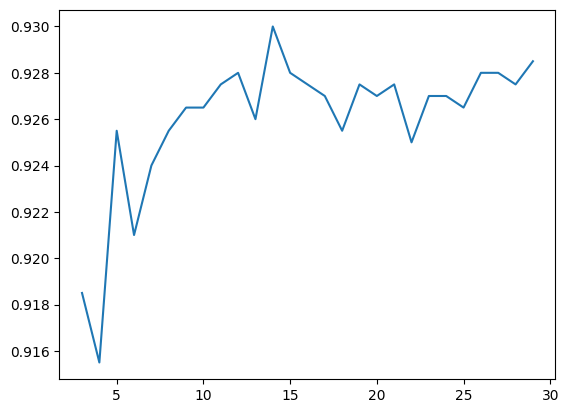

In [249]:
plt.plot(scores)